## Final Project Submission

Please fill out:
* Student name: Abigail Campbell
* Student pace: Flex
* Scheduled project review date/time: 
* Instructor name: Morgan Jones
* Blog post URL:


# Setup

### Import relevant packages

In [1]:
import sqlite3 
import pandas as pd
import numpy as np
import zipfile
import scipy.stats as stats
import statsmodels.api as sm

import seaborn as sns
import matplotlib.pyplot as plt
# plt.style.use('seaborn-v0_8-whitegrid')
%matplotlib inline

### Load data

In [2]:
# unzip imdb
with zipfile.ZipFile('zippedData/im.db.zip', 'r') as zip_ref:
    zip_ref.extractall('zippedData')
    
# create connection to the SQL database
conn = sqlite3.connect('zippedData/im.db')

# load data
gross = pd.read_csv('zippedData/bom.movie_gross.csv.gz', thousands=',')
movie_info = pd.read_csv('zippedData/rt.movie_info.tsv.gz', sep='\t', thousands=',')
reviews = pd.read_csv('zippedData/rt.reviews.tsv.gz', sep='\t', encoding='unicode_escape')
budgets = pd.read_csv('zippedData/tn.movie_budgets.csv.gz', thousands=',')
tmdb = pd.read_csv('zippedData/tmdb.movies.csv.gz')

In [3]:
movie_info.head()
# budgets.head()

,id,synopsis,rating,genre,director,writer,theater_date,dvd_date,currency,box_office,runtime,studio
0,1,"This gritty, fast-paced, and innovative police...",R,Action and Adventure|Classics|Drama,William Friedkin,Ernest Tidyman,"Oct 9, 1971","Sep 25, 2001",NaN,NaN,104 minutes,NaN
1,3,"New York City, not-too-distant-future: Eric Pa...",R,Drama|Science Fiction and Fantasy,David Cronenberg,David Cronenberg|Don DeLillo,"Aug 17, 2012","Jan 1, 2013",$,600000.0,108 minutes,Entertainment One
2,5,Illeana Douglas delivers a superb performance ...,R,Drama|Musical and Performing Arts,Allison Anders,Allison Anders,"Sep 13, 1996","Apr 18, 2000",NaN,NaN,116 minutes,NaN
3,6,Michael Douglas runs afoul of a treacherous su...,R,Drama|Mystery and Suspense,Barry Levinson,Paul Attanasio|Michael Crichton,"Dec 9, 1994","Aug 27, 1997",NaN,NaN,128 minutes,NaN
4,7,NaN,NR,Drama|Romance,Rodney Bennett,Giles Cooper,NaN,NaN,NaN,NaN,200 minutes,NaN


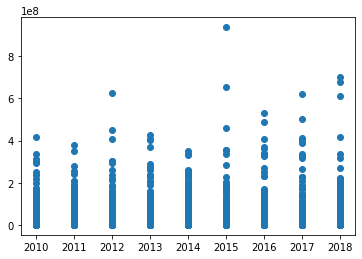

In [4]:
plt.scatter(gross.year, gross.domestic_gross)

In [5]:
pd.read_sql("""
    SELECT * 
        FROM directors
    """, conn)

,movie_id,person_id
0,tt0285252,nm0899854
1,tt0462036,nm1940585
2,tt0835418,nm0151540
3,tt0835418,nm0151540
4,tt0878654,nm0089502
...,...,...
291169,tt8999974,nm10122357
291170,tt9001390,nm6711477
291171,tt9001494,nm10123242
291172,tt9001494,nm10123248


# Data Cleaning

### Gross Earnings

In [6]:
# remove all data points from gross that don't include domestic gross earnings or the studio name
gross = gross.dropna(axis=0, subset=['domestic_gross', 'studio'])

# fill Nan numbers in foreign_gross with 0 - assuming that the movie was not released foriegn
gross['foreign_gross'] = gross['foreign_gross'].fillna('0')

# convert foreign_gross column from object to float
gross['foreign_gross'] = pd.to_numeric(gross['foreign_gross'])

gross.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3356 entries, 0 to 3386
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           3356 non-null   object 
 1   studio          3356 non-null   object 
 2   domestic_gross  3356 non-null   float64
 3   foreign_gross   3356 non-null   float64
 4   year            3356 non-null   int64  
dtypes: float64(2), int64(1), object(2)
memory usage: 157.3+ KB


### Movie Info

runtime note: value = integers, but each integer is followed by 'minutes'

dates note: given as month day, year format

    - month is in the three letter format
    - day is given as 1 or 2 digits (does not put a 0 in from on single digit days)
    - year is alwasy 4 digits

In [7]:
# drop columns that are irrelevent
movie_info = movie_info.drop(['currency', 'writer', 'runtime', 'synopsis', 'box_office', 'dvd_date'], axis=1)

In [8]:
# remove NaN rows for genre
movie_info = movie_info.dropna(axis=0, subset=['genre'])

# separate genre into a list of genres
movie_info['genre'] = movie_info['genre'].map(lambda x: x.split('|'))

In [9]:
movie_info.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1552 entries, 0 to 1559
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            1552 non-null   int64 
 1   rating        1552 non-null   object
 2   genre         1552 non-null   object
 3   director      1360 non-null   object
 4   theater_date  1201 non-null   object
 5   studio        494 non-null    object
dtypes: int64(1), object(5)
memory usage: 84.9+ KB


### Reviews

Review format = rating/total possible

Fresh = fresh and rotten are the only two values - will probably use this as the rating metric

Date: given as month day, year format
- month is in the three letter format
- day is given as 1 or 2 digits (does not put a 0 in from on single digit days)
- year is alwasy 4 digits

In [10]:
# convert fresh column to 0 (rotten) or 1 (fresh)
reviews['fresh_rating'] = reviews['fresh'].map(lambda x: 0 if 'rotten' in x else 1)

reviews.info()
reviews['fresh_rating'].value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54432 entries, 0 to 54431
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            54432 non-null  int64 
 1   review        48869 non-null  object
 2   rating        40915 non-null  object
 3   fresh         54432 non-null  object
 4   critic        51710 non-null  object
 5   top_critic    54432 non-null  int64 
 6   publisher     54123 non-null  object
 7   date          54432 non-null  object
 8   fresh_rating  54432 non-null  int64 
dtypes: int64(3), object(6)
memory usage: 3.7+ MB


1    33035
0    21397
Name: fresh_rating, dtype: int64

### Budgets

The budget and gross columns contain a dollar sign at the beginning of the value, as well as columns to separate out thousands.

remove the dollar sign and commas from the string, then convert to an interger

In [11]:
# format the money columns to be integers, without the $ sign
budgets['production_budget'] = budgets['production_budget'].map(lambda x: int(x[1:].replace(',', '')))
budgets['domestic_gross'] = budgets['domestic_gross'].map(lambda x: int(x[1:].replace(',', '')))
budgets['worldwide_gross'] = budgets['worldwide_gross'].map(lambda x: int(x[1:].replace(',', '')))   

### TMDB

looks clean

In [12]:
tmdb.info()
tmdb.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26517 entries, 0 to 26516
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         26517 non-null  int64  
 1   genre_ids          26517 non-null  object 
 2   id                 26517 non-null  int64  
 3   original_language  26517 non-null  object 
 4   original_title     26517 non-null  object 
 5   popularity         26517 non-null  float64
 6   release_date       26517 non-null  object 
 7   title              26517 non-null  object 
 8   vote_average       26517 non-null  float64
 9   vote_count         26517 non-null  int64  
dtypes: float64(2), int64(3), object(5)
memory usage: 2.0+ MB


,Unnamed: 0,genre_ids,id,original_language,original_title,popularity,release_date,title,vote_average,vote_count
0,0,"[12, 14, 10751]",12444,en,Harry Potter and the Deathly Hallows: Part 1,33.533,2010-11-19,Harry Potter and the Deathly Hallows: Part 1,7.7,10788
1,1,"[14, 12, 16, 10751]",10191,en,How to Train Your Dragon,28.734,2010-03-26,How to Train Your Dragon,7.7,7610
2,2,"[12, 28, 878]",10138,en,Iron Man 2,28.515,2010-05-07,Iron Man 2,6.8,12368
3,3,"[16, 35, 10751]",862,en,Toy Story,28.005,1995-11-22,Toy Story,7.9,10174
4,4,"[28, 878, 12]",27205,en,Inception,27.920,2010-07-16,Inception,8.3,22186


# Create tables with relevant information

## Budgets Table

In [13]:
budgets = budgets.rename(columns={'movie': 'title'})
budgets = budgets.set_index('title')

budgets['domestic_roi'] = budgets['domestic_gross']/budgets['production_budget']
budgets['worldwide_roi'] = budgets['worldwide_gross']/budgets['production_budget']

budgets.head(10)

,id,release_date,production_budget,domestic_gross,worldwide_gross,domestic_roi,worldwide_roi
title,,,,,,,
Avatar,1,"Dec 18, 2009",425000000,760507625,2776345279,1.789430,6.532577
Pirates of the Caribbean: On Stranger Tides,2,"May 20, 2011",410600000,241063875,1045663875,0.587101,2.546673
Dark Phoenix,3,"Jun 7, 2019",350000000,42762350,149762350,0.122178,0.427892
Avengers: Age of Ultron,4,"May 1, 2015",330600000,459005868,1403013963,1.388403,4.243841
Star Wars Ep. VIII: The Last Jedi,5,"Dec 15, 2017",317000000,620181382,1316721747,1.956408,4.153696
Star Wars Ep. VII: The Force Awakens,6,"Dec 18, 2015",306000000,936662225,2053311220,3.060988,6.710167
Avengers: Infinity War,7,"Apr 27, 2018",300000000,678815482,2048134200,2.262718,6.827114
Pirates of the Caribbean: At Worldâs End,8,"May 24, 2007",300000000,309420425,963420425,1.031401,3.211401
Justice League,9,"Nov 17, 2017",300000000,229024295,655945209,0.763414,2.186484


## Movie info table

In [14]:
# combine budgets and movie info dataframs
# movie_info = movie_info.set_index('id')
# budgets = budgets.set_index('id')

sql_movie_basics = pd.read_sql("""
                                SELECT movie_id, primary_title, start_year, genres
                                    FROM movie_basics
                                """, conn)

sql_movie_basics = sql_movie_basics.rename(columns={'primary_title': 'title'})
sql_movie_basics = sql_movie_basics.set_index('title')
sql_movie_basics.head(10)

,movie_id,start_year,genres
title,,,
Sunghursh,tt0063540,2013,"Action,Crime,Drama"
One Day Before the Rainy Season,tt0066787,2019,"Biography,Drama"
The Other Side of the Wind,tt0069049,2018,Drama
Sabse Bada Sukh,tt0069204,2018,"Comedy,Drama"
The Wandering Soap Opera,tt0100275,2017,"Comedy,Drama,Fantasy"
A Thin Life,tt0111414,2018,Comedy
Bigfoot,tt0112502,2017,"Horror,Thriller"
Joe Finds Grace,tt0137204,2017,"Adventure,Animation,Comedy"
O Silêncio,tt0139613,2012,"Documentary,History"


## Directors table

In [15]:
director_table = pd.read_sql("""
    SELECT m.primary_title, p.primary_name, r.averagerating
        FROM movie_basics as m
        JOIN directors as d
            ON m.movie_id = d.movie_id
        JOIN persons as p
            USING(person_id)
        JOIN movie_ratings as r
            USING(movie_id)
    """, conn)
director_table = director_table.drop_duplicates(keep='last')
director_table = director_table.rename(columns={'primary_title': 'title'})
director_table = director_table.set_index('title')

director_table.head(10)

,primary_name,averagerating
title,,
Sunghursh,Harnam Singh Rawail,7.0
One Day Before the Rainy Season,Mani Kaul,7.2
The Other Side of the Wind,Orson Welles,6.9
Sabse Bada Sukh,Hrishikesh Mukherjee,6.1
The Wandering Soap Opera,Raoul Ruiz,6.5
The Wandering Soap Opera,Valeria Sarmiento,6.5
Bigfoot,Mc Jones,4.1
Joe Finds Grace,Anthony Harrison,8.1
Pál Adrienn,Ágnes Kocsis,6.8


# Combine tables to get the specific metrics

## Combine budgets table and movie info table

In [17]:
budgets_basics = sql_movie_basics.join(budgets, how='inner')
budgets_basics['release_year'] = budgets_basics['release_date'].map(lambda x: int(x[-4:]))
budgets_basics['release_month'] = budgets_basics['release_date'].map(lambda x: x[0:4])
budgets_basics_2 = budgets_basics[(budgets_basics["release_year"] - budgets_basics["start_year"] <= 1) & (budgets_basics["release_year"] > budgets_basics["start_year"])].copy()
budgets_basics_2.to_csv('data/budgets_basics_2.csv')
budgets_basics_2.head(10)

,movie_id,start_year,genres,id,release_date,production_budget,domestic_gross,worldwide_gross,domestic_roi,worldwide_roi,release_year,release_month
title,,,,,,,,,,,,
1982,tt5671400,2015,Documentary,23,"Mar 1, 2016",1000000,0,0,0.000000,0.000000,2016,Mar
3,tt1517177,2010,"Comedy,Drama,Romance",85,"Sep 16, 2011",7200000,59774,295492,0.008302,0.041041,2011,Sep
3 Backyards,tt1314190,2010,Drama,51,"Mar 11, 2011",300000,39475,39475,0.131583,0.131583,2011,Mar
50/50,tt1734060,2010,Documentary,73,"Sep 30, 2011",8000000,35016118,41334735,4.377015,5.166842,2011,Sep
8 Days,tt3111864,2014,"Drama,Thriller",48,"Oct 13, 2015",2500000,0,0,0.000000,0.000000,2015,Oct
A Little Bit of Heaven,tt1440161,2011,"Comedy,Drama,Fantasy",39,"May 4, 2012",12500000,10011,1100287,0.000801,0.088023,2012,May
A Lonely Place to Die,tt1422136,2011,"Adventure,Crime,Thriller",56,"Mar 20, 2012",4000000,0,442550,0.000000,0.110637,2012,Mar
A Monster Calls,tt3416532,2016,"Animation,Drama,Fantasy",41,"Jan 6, 2017",43000000,3740823,46414530,0.086996,1.079408,2017,Jan
A.C.O.R.N.S.: Operation Crackdown,tt2097333,2015,"Animation,Comedy,Family",51,"Nov 1, 2016",8500000,0,1353287,0.000000,0.159210,2016,Nov


### organize by genre

In [18]:
# split the genre column to get a list of genres
budgets_basics_2['genres'] = budgets_basics_2['genres'].map(lambda x: x.split(','))

# give each movie a row for each individual genre
split_genres = budgets_basics_2.explode('genres')
split_genres.head(10)

,movie_id,start_year,genres,id,release_date,production_budget,domestic_gross,worldwide_gross,domestic_roi,worldwide_roi,release_year,release_month
title,,,,,,,,,,,,
1982,tt5671400,2015,Documentary,23,"Mar 1, 2016",1000000,0,0,0.000000,0.000000,2016,Mar
3,tt1517177,2010,Comedy,85,"Sep 16, 2011",7200000,59774,295492,0.008302,0.041041,2011,Sep
3,tt1517177,2010,Drama,85,"Sep 16, 2011",7200000,59774,295492,0.008302,0.041041,2011,Sep
3,tt1517177,2010,Romance,85,"Sep 16, 2011",7200000,59774,295492,0.008302,0.041041,2011,Sep
3 Backyards,tt1314190,2010,Drama,51,"Mar 11, 2011",300000,39475,39475,0.131583,0.131583,2011,Mar
50/50,tt1734060,2010,Documentary,73,"Sep 30, 2011",8000000,35016118,41334735,4.377015,5.166842,2011,Sep
8 Days,tt3111864,2014,Drama,48,"Oct 13, 2015",2500000,0,0,0.000000,0.000000,2015,Oct
8 Days,tt3111864,2014,Thriller,48,"Oct 13, 2015",2500000,0,0,0.000000,0.000000,2015,Oct
A Little Bit of Heaven,tt1440161,2011,Comedy,39,"May 4, 2012",12500000,10011,1100287,0.000801,0.088023,2012,May


In [19]:
genre_roi = split_genres.groupby('genres').mean()
genre_roi.to_csv('data/genre_roi.csv')
genre_roi

,start_year,id,production_budget,domestic_gross,worldwide_gross,domestic_roi,worldwide_roi,release_year
genres,,,,,,,,
Action,2013.938776,53.489796,2.628469e+07,1.818222e+07,5.953479e+07,1.581541,3.369272,2014.938776
Adventure,2014.151515,51.636364,3.242064e+07,1.457980e+07,5.597203e+07,0.692266,1.774898,2015.151515
Animation,2015.250000,46.000000,3.047500e+07,5.606678e+06,4.495455e+07,0.479348,2.409407,2016.250000
Biography,2013.727273,56.454545,1.792591e+07,1.548005e+07,3.684396e+07,0.598981,1.592714,2014.727273
Comedy,2012.858974,53.256410,1.136208e+07,1.068256e+07,2.775345e+07,1.111372,2.498699,2013.858974
Crime,2012.808511,51.765957,9.246298e+06,5.362153e+06,1.274626e+07,0.956727,1.921779,2013.808511
Documentary,2013.613636,49.840909,2.145795e+07,2.979813e+07,6.241342e+07,0.892846,1.538960,2014.613636
Drama,2013.202128,51.462766,1.144520e+07,1.223826e+07,2.749768e+07,1.446080,2.818608,2014.202128
Family,2014.111111,50.777778,2.913333e+07,3.023755e+07,8.116044e+07,0.658371,2.129482,2015.111111


## organize by release month

In [20]:
month_sums = split_genres.groupby('release_month').sum()
month_sums.to_csv('data/month_sums.csv')

month_means = split_genres.groupby('release_month').mean()
month_means.to_csv('data/month_means.csv')

month_sums

,start_year,id,production_budget,domestic_gross,worldwide_gross,domestic_roi,worldwide_roi,release_year
release_month,,,,,,,,
Apr,283810,7506,1299580000,780332151,1459047085,332.910335,574.657394,283951
Aug,86510,2240,412175000,342839930,651955687,37.749831,65.885694,86553
Dec,44284,888,208444000,101042976,212237671,4.041719,10.092529,44306
Feb,153054,4090,2246460000,976807466,3991835112,56.782839,118.575261,153130
Jan,239668,7015,1993348000,3279501017,8352644006,417.809723,910.372203,239787
Jul,52324,1326,123525000,82188714,166263805,5.717946,12.376201,52350
Jun,134889,3837,1155602119,1495960741,3504818444,58.734730,156.358992,134956
Mar,183203,4176,1481786173,1241569330,2782780666,88.605486,156.067886,183294
May,124814,2390,752548000,1064930786,2423618608,74.816507,148.335455,124876


## Combine directors table and budgets table

In [21]:
budgets_directors = director_table.join(budgets, how='inner')
budgets_directors.to_csv('data/budgets_directors.csv')
budgets_directors.head(30)

,primary_name,averagerating,id,release_date,production_budget,domestic_gross,worldwide_gross,domestic_roi,worldwide_roi
title,,,,,,,,,
#Horror,Tara Subkoff,3.0,16,"Nov 20, 2015",1500000,0,0,0.000000,0.000000
10 Cloverfield Lane,Dan Trachtenberg,7.2,54,"Mar 11, 2016",5000000,72082999,108286422,14.416600,21.657284
10 Days in a Madhouse,Timothy Hines,6.7,48,"Nov 11, 2015",12000000,14616,14616,0.001218,0.001218
12 Rounds,Gabriel Soriano,8.1,37,"Mar 27, 2009",20000000,12234694,17306648,0.611735,0.865332
12 Strong,Nicolai Fuglsig,6.6,64,"Jan 19, 2018",35000000,45819713,71118378,1.309135,2.031954
12 Years a Slave,Steve McQueen,8.1,18,"Oct 18, 2013",20000000,56671993,181025343,2.833600,9.051267
127 Hours,Danny Boyle,7.6,6,"Nov 5, 2010",18000000,18335230,60217171,1.018624,3.345398
13 Sins,Daniel Stamm,6.3,51,"Apr 18, 2014",4000000,9134,47552,0.002283,0.011888
1982,Tommy Oliver,7.0,23,"Mar 1, 2016",1000000,0,0,0.000000,0.000000


## Group by director and get average domestic and worldwide ROI

In [22]:
director_roi = budgets_directors.groupby('primary_name').mean()
director_roi.to_csv('data/director_roi.csv')
director_roi

,averagerating,id,production_budget,domestic_gross,worldwide_gross,domestic_roi,worldwide_roi
primary_name,,,,,,,
Aaron Alon,7.9,79.0,2100000.0,881824.0,1381824.0,0.419916,0.658011
Aaron Hann,6.0,69.0,2000000.0,10024.0,10024.0,0.005012,0.005012
Aaron Seltzer,3.4,49.0,20000000.0,36661504.0,81424988.0,1.833075,4.071249
Aaron T. Wells,3.5,74.0,500000.0,0.0,0.0,0.000000,0.000000
Aash Aaron,8.1,2.0,3500000.0,12600000.0,12600000.0,3.600000,3.600000
...,...,...,...,...,...,...,...
Zsófia Szilágyi,7.2,84.0,15000000.0,13843771.0,59168692.0,0.922918,3.944579
Zuri Rinpoche,5.8,83.0,12000000.0,22673340.0,22673340.0,1.889445,1.889445
Éric Tessier,6.6,33.0,30000000.0,31749894.0,48559999.0,1.058330,1.618667
